In [92]:
import numpy as np
import pandas as pd
# settings to display all columns
pd.set_option("display.max_columns", None)

import matplotlib.pyplot as plt
import seaborn as sns


In [65]:
status = pd.read_csv('../../data/status.csv', index_col='id')
info = pd.read_csv('../../data/data.csv', index_col='id')

In [66]:
status.value_counts()

status_group           
functional                 32259
non functional             22824
functional needs repair     4317
dtype: int64

In [67]:
status.value_counts(normalize=True)

status_group           
functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
dtype: float64

In [68]:
info.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [69]:
status.head()

,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional


In [70]:
info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55765 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59400 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15

In [71]:
status.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   status_group  59400 non-null  object
dtypes: object(1)
memory usage: 928.1+ KB


In [72]:
data = pd.merge(status, info, on='id')

In [73]:
data

,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60739,functional,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,Pangani,Kiduruni,Kilimanjaro,3,5,Hai,Masama Magharibi,125,True,GeoData Consultants Ltd,Water Board,Losaa Kia water supply,True,1999,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
27263,functional,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,Rufiji,Igumbilo,Iringa,11,4,Njombe,Ikondo,56,True,GeoData Consultants Ltd,VWC,Ikondo electrical water sch,True,1996,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
37057,functional,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump


In [74]:
# drop duplicates
data.drop_duplicates(inplace=True)

In [75]:
data['amount_tsh'].value_counts(normalize=True)*100

0.0         70.081194
500.0        5.225389
50.0         4.164140
1000.0       2.506570
20.0         2.464457
              ...    
8500.0       0.001685
6300.0       0.001685
220.0        0.001685
138000.0     0.001685
12.0         0.001685
Name: amount_tsh, Length: 98, dtype: float64

In [76]:
(data == 0).sum(axis=0)/len(data)*100

status_group              0.000000
amount_tsh               70.081194
date_recorded             0.000000
funder                    0.000000
gps_height               34.367630
installer                 0.000000
longitude                 2.993397
latitude                  0.000000
wpt_name                  0.000000
num_private              98.724816
basin                     0.000000
subvillage                0.000000
region                    0.000000
region_code               0.000000
district_code             0.038744
lga                       0.000000
ward                      0.000000
population               35.956135
public_meeting            8.513577
recorded_by               0.000000
scheme_management         0.000000
scheme_name               0.000000
permit                   29.428610
construction_year        34.824136
extraction_type           0.000000
extraction_type_group     0.000000
extraction_type_class     0.000000
management                0.000000
management_group    

In [77]:
# null values in each column as %
data.isna().sum()/len(data)*100

status_group              0.000000
amount_tsh                0.000000
date_recorded             0.000000
funder                    6.123240
gps_height                0.000000
installer                 6.156930
longitude                 0.000000
latitude                  0.000000
wpt_name                  0.000000
num_private               0.000000
basin                     0.000000
subvillage                0.624958
region                    0.000000
region_code               0.000000
district_code             0.000000
lga                       0.000000
ward                      0.000000
population                0.000000
public_meeting            5.582508
recorded_by               0.000000
scheme_management         6.530894
scheme_name              47.400782
permit                    5.147901
construction_year         0.000000
extraction_type           0.000000
extraction_type_group     0.000000
extraction_type_class     0.000000
management                0.000000
management_group    

In [78]:
data.funder.value_counts(normalize=True).head(40)

Government Of Tanzania            0.162860
Danida                            0.055878
Hesawa                            0.039441
Rwssp                             0.024619
World Bank                        0.024206
Kkkt                              0.023094
World Vision                      0.022358
Unicef                            0.018967
Tasaf                             0.015737
District Council                  0.015127
Dhv                               0.014876
Private Individual                0.014822
Dwsp                              0.014373
0                                 0.013942
Norad                             0.013727
Germany Republi                   0.010946
Tcrs                              0.010802
Ministry Of Water                 0.010587
Water                             0.010461
Dwe                               0.008685
Netherlands                       0.008434
Hifab                             0.008075
Adb                               0.008039
Lga        

In [79]:
data.drop(columns='funder')

,status_group,amount_tsh,date_recorded,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,functional,6000.0,2011-03-14,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,functional,0.0,2013-03-06,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,functional,25.0,2013-02-25,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,non functional,0.0,2013-01-28,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,functional,0.0,2011-07-13,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60739,functional,10.0,2013-05-03,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,Pangani,Kiduruni,Kilimanjaro,3,5,Hai,Masama Magharibi,125,True,GeoData Consultants Ltd,Water Board,Losaa Kia water supply,True,1999,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
27263,functional,4700.0,2011-05-07,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,Rufiji,Igumbilo,Iringa,11,4,Njombe,Ikondo,56,True,GeoData Consultants Ltd,VWC,Ikondo electrical water sch,True,1996,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
37057,functional,0.0,2011-04-11,0,NaN,34.017087,-8.750434,Mashine,0,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump


In [80]:
data.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59364.000000,59364.000000,59364.000000,5.936400e+04,59364.000000,59364.000000,59364.000000,59364.000000,59364.000000
mean,317.843017,668.702513,34.097560,-5.709463e+00,0.474429,15.295516,5.631494,180.019086,1301.441227
std,2998.473133,693.131013,6.517065,2.943608e+00,12.239934,17.592619,9.636138,471.604294,951.369704
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.095187,-8.541904e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,370.000000,34.910318,-5.023822e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1320.000000,37.179490,-3.326918e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [81]:
data.amount_tsh.sort_values(ascending=False).head(30)

id
41564    350000.0
4128     250000.0
7860     200000.0
70107    170000.0
54154    138000.0
15191    120000.0
71707    117000.0
15801    117000.0
64148    117000.0
38117    117000.0
18724    117000.0
7737     117000.0
4712     117000.0
45188    100000.0
10996    100000.0
69674    100000.0
65614     70000.0
58336     60000.0
24876     50000.0
13946     50000.0
35268     50000.0
3252      50000.0
73818     45000.0
28057     45000.0
30855     45000.0
40048     40000.0
73094     40000.0
28620     40000.0
48346     40000.0
50998     40000.0
Name: amount_tsh, dtype: float64

In [88]:
data['population'].value_counts()

0       21345
1        7025
200      1940
150      1892
250      1681
        ...  
3241        1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1049, dtype: int64

In [83]:
cat_cols = []

for col in data.columns:
    if data[col].dtype in ['object']:
        cat_cols.append(col)

In [84]:
data[cat_cols].describe()

,status_group,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,59364,59364,55729,55709,59364,59364,58993,59364,59364,59364,56050,59364,55487,31225,56308,59364,59364,59364,59364,59364,59364,59364,59364,59364,59364,59364,59364,59364,59364,59364,59364
unique,3,356,1897,2145,37400,9,19287,21,125,2092,2,1,12,2696,2,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6
top,functional,2011-03-15,Government Of Tanzania,DWE,none,Lake Victoria,Shuleni,Iringa,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,32237,572,9076,17385,3561,10212,505,5294,2503,307,50996,59364,36779,682,38838,26776,26776,26776,40493,52456,25337,25337,50785,50785,33165,33165,17020,17020,45764,28516,34615


In [85]:
data[cat_cols].isna().sum()/len(data)*100

status_group              0.000000
date_recorded             0.000000
funder                    6.123240
installer                 6.156930
wpt_name                  0.000000
basin                     0.000000
subvillage                0.624958
region                    0.000000
lga                       0.000000
ward                      0.000000
public_meeting            5.582508
recorded_by               0.000000
scheme_management         6.530894
scheme_name              47.400782
permit                    5.147901
extraction_type           0.000000
extraction_type_group     0.000000
extraction_type_class     0.000000
management                0.000000
management_group          0.000000
payment                   0.000000
payment_type              0.000000
water_quality             0.000000
quality_group             0.000000
quantity                  0.000000
quantity_group            0.000000
source                    0.000000
source_type               0.000000
source_class        

In [86]:
((data[cat_cols] == 'None')|(data[cat_cols] == 'none')).sum(axis=0)/len(data)*100

status_group             0.000000
date_recorded            0.000000
funder                   0.003369
installer                0.000000
wpt_name                 6.001954
basin                    0.000000
subvillage               0.000000
region                   0.000000
lga                      0.000000
ward                     0.000000
public_meeting           0.000000
recorded_by              0.000000
scheme_management        0.001685
scheme_name              1.126946
permit                   0.000000
extraction_type          0.000000
extraction_type_group    0.000000
extraction_type_class    0.000000
management               0.000000
management_group         0.000000
payment                  0.000000
payment_type             0.000000
water_quality            0.000000
quality_group            0.000000
quantity                 0.000000
quantity_group           0.000000
source                   0.000000
source_type              0.000000
source_class             0.000000
waterpoint_typ

In [87]:
((data[cat_cols] == 'Unknown')|(data[cat_cols] == 'unknown')).sum(axis=0)/len(data)*100

status_group              0.000000
date_recorded             0.000000
funder                    0.006738
installer                 0.006738
wpt_name                  0.005054
basin                     0.000000
subvillage                0.000000
region                    0.000000
lga                       0.000000
ward                      0.000000
public_meeting            0.000000
recorded_by               0.000000
scheme_management         0.000000
scheme_name               0.000000
permit                    0.000000
extraction_type           0.000000
extraction_type_group     0.000000
extraction_type_class     0.000000
management                0.945017
management_group          0.945017
payment                  13.701907
payment_type             13.701907
water_quality             3.155111
quality_group             3.155111
quantity                  1.329088
quantity_group            1.329088
source                    0.111178
source_type               0.000000
source_class        

In [41]:
for col in cat_cols:
    print(f'{col}:')
    print(data[col].value_counts(normalize=True))
    print('<>'*5)

status_group:
functional                 0.54304
non functional             0.38429
functional needs repair    0.07267
Name: status_group, dtype: float64
<><><><><>
date_recorded:
2011-03-15    0.009635
2011-03-17    0.009400
2013-02-03    0.009197
2011-03-14    0.008760
2011-03-16    0.008642
                ...   
2011-09-19    0.000017
2011-09-14    0.000017
2012-01-21    0.000017
2011-09-16    0.000017
2011-09-09    0.000017
Name: date_recorded, Length: 356, dtype: float64
<><><><><>
funder:
Government Of Tanzania    0.162860
Danida                    0.055878
Hesawa                    0.039441
Rwssp                     0.024619
World Bank                0.024206
                            ...   
Makundya                  0.000018
Doner And Ded             0.000018
Tz As                     0.000018
Ripati                    0.000018
Tancro                    0.000018
Name: funder, Length: 1897, dtype: float64
<><><><><>
installer:
DWE                         0.312068
Government  

spring                  0.286706
shallow well            0.283017
borehole                0.201183
river/lake              0.174769
rainwater harvesting    0.038626
dam                     0.011034
other                   0.004666
Name: source_type, dtype: float64
<><><><><>
source_class:
groundwater    0.770905
surface        0.224429
unknown        0.004666
Name: source_class, dtype: float64
<><><><><>
waterpoint_type:
communal standpipe             0.480358
hand pump                      0.294219
other                          0.107422
communal standpipe multiple    0.102739
improved spring                0.013190
cattle trough                  0.001954
dam                            0.000118
Name: waterpoint_type, dtype: float64
<><><><><>
waterpoint_type_group:
communal standpipe    0.583098
hand pump             0.294219
other                 0.107422
improved spring       0.013190
cattle trough         0.001954
dam                   0.000118
Name: waterpoint_type_group, dtype: f

To do, *~categorical~*:
date_recorded - drop
funder - maybe keep? use with fancy encoder
installer - fancy encoder
wpt_name - drop
basin - FE
subvillage - too many, drop
region - use instead of region_code and district_code
lga - FE (*droppable*)
ward - drop
public_meeting - drop
recorded_by - drop
secheme_magnement - FE
secheme_neme - drop
permit - binary encode
extraction_type & extraction_type_group - drop
extraction_type_class - keep, encode
management - drop
management_group - FE
payment - FE
payment_type - drop (*droppable*)
water_quality - drop
quality_group - FE
quantity - FE
quantity_group - drop (same)
source over source_type, keep source_class
waterpoint_type_group over waterpoint_type

In [45]:
data[data['permit'] == True]['status_group'].value_counts(normalize=True)

functional                 0.554405
non functional             0.376152
functional needs repair    0.069442
Name: status_group, dtype: float64

In [47]:
data['extraction_type']

id
69572        gravity
8776         gravity
34310        gravity
67743    submersible
19728        gravity
            ...     
60739        gravity
27263        gravity
37057         swn 80
31282    nira/tanira
26348    nira/tanira
Name: extraction_type, Length: 59364, dtype: object

In [53]:
data.groupby(['status_group','extraction_type']).size()/len(data)*100

status_group             extraction_type          
functional               afridev                       2.019743
                         cemo                          0.075804
                         climax                        0.013476
                         gravity                      27.029850
                         india mark ii                 2.435820
                         india mark iii                0.074119
                         ksb                           1.184219
                         mono                          1.822653
                         nira/tanira                   9.116636
                         other                         1.733374
                         other - play pump             0.048851
                         other - rope pump             0.493565
                         other - swn 81                0.202143
                         submersible                   4.416818
                         swn 80                      

In [54]:
data.groupby(['status_group','management']).size()/len(data)*100

status_group             management      
functional               company              0.449768
                         other                0.850684
                         other - school       0.038744
                         parastatal           1.716529
                         private operator     2.486355
                         trust                0.077488
                         unknown              0.377333
                         vwc                 34.391214
                         water authority      0.751297
                         water board          3.655414
                         wua                  2.949599
                         wug                  6.559531
functional needs repair  company              0.025268
                         other                0.092649
                         other - school       0.001685
                         parastatal           0.353750
                         private operator     0.074119
                       

In [55]:
data.groupby(['status_group','water_quality']).size()/len(data)*100

status_group             water_quality     
functional               coloured               0.414393
                         fluoride               0.254363
                         fluoride abandoned     0.010107
                         milky                  0.737821
                         salty                  3.739640
                         salty abandoned        0.293107
                         soft                  48.409811
                         unknown                0.444714
functional needs repair  coloured               0.090964
                         fluoride               0.021899
                         milky                  0.023583
                         salty                  0.379018
                         salty abandoned        0.121286
                         soft                   6.571323
                         unknown                0.058958
non functional           coloured               0.320059
                         fluoride           

In [90]:
drop_cols = ['num_private', 'region_code', 'district_code', 'date_recorded', 
             'wpt_name', 'subvillage', 'ward', 'public_meeting',
             'recorded_by', 'scheme_name', 'extraction_type', 'extraction_type_group',
             'management', 'payment_type', 'water_quality', 'quantity_group',
             'source_type', 'waterpoint_type']
data.drop(columns=drop_cols, inplace=True)

In [91]:
num_cols = []
ohe_cols = []
freq_cols = []

for c in data.columns:
    if data[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    elif data[c].nunique() < 10:
        ohe_cols.append(c)
    else:
        freq_cols.append(c)
        
print(num_cols, ohe_cols, freq_cols)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population', 'construction_year'] ['status_group', 'basin', 'permit', 'extraction_type_class', 'management_group', 'payment', 'quality_group', 'quantity', 'source_class', 'waterpoint_type_group'] ['funder', 'installer', 'region', 'lga', 'scheme_management', 'source']


<AxesSubplot:>

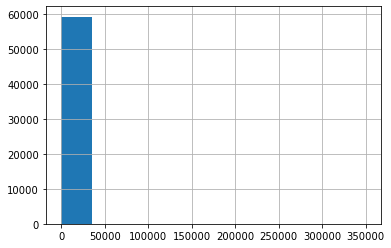

In [95]:
data['amount_tsh'].hist()

<AxesSubplot:>

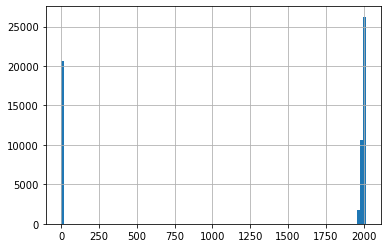

In [96]:
data['construction_year'].hist(bins=100)

<AxesSubplot:>

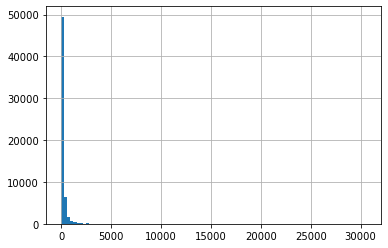

In [97]:
data['population'].hist(bins=100)

In [100]:
(data['longitude'] == 0).sum()

1777

In [101]:
(data['latitude'] == 0).sum()

0

In [103]:
data[data['longitude'] == 0]['latitude'].value_counts()

-2.000000e-08    1777
Name: latitude, dtype: int64